In [4]:
!pip install bert-for-tf2
!pip install sentencepiece

     |████████████████████████████████| 40kB 3.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.4-cp36-none-any.whl size=30114 sha256=d686940ebf5a55d5ca4ee1a5909f80195243b6be7723bac2935fba13628cb7d6
  Stored in directory: /root/.cache/pip/wheels/cf/3f/4d/79d7735015a5f523648df90d871ce8e89a7df8185f7703eeab
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=37797436b9a41ddabff30e34af79d78773e5c3680012905321aa8863315c1aa9
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19473 sha256=983f66e40e42c5e092e746f88905110d7f522c7c44b09c3b67f4ceb864cdf4f8
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow
     |████████████████████████████████| 1.1MB 8.3MB/s 


### IMPORT

In [0]:
import pandas as pd
import numpy as np
try:
  %tensorflow_version 2.x
except:
  pass
import tensorflow as tf
from google.colab import drive
import tensorflow_hub as hub

from tensorflow.keras import layers
import bert
import random
import math
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model
import pickle

In [6]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
X,y =pickle.load(open('/content/drive/My Drive/NewsClassifier/final_dataset','rb'))

#### USING BERT TOKENIZER

In [0]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [0]:
tag2idx ={}
c=0
for tag in set(y):
    tag2idx[tag] = c
    c+=1
idx2tag = { v:k for k,v in tag2idx.items()}

In [0]:
 data_X = [tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentence)) for sentence in X]
 data_y = [tag2idx[tag] for tag in y]

### SPLITTING OF SKEWED DATA

In [11]:
skf = StratifiedShuffleSplit(n_splits=2,test_size=0.2)
skf.get_n_splits(data_X,data_y )

2

In [0]:
X_array = np.array(data_X)
y_array = np.array(data_y)

In [13]:
for train_index,test_index in skf.split(data_X,data_y):   ## Splitting into train and test_set
  print("TRAIN:", train_index, "TEST:", test_index)
  #print(len(train_index))
  X_train,X_test = X_array[train_index], X_array[test_index]
  y_train,y_test = y_array[train_index], y_array[test_index]


TRAIN: [148427 111337 122695 ... 146636  55805 175548] TEST: [ 57885  70815   7028 ...  36077 159925 111613]
TRAIN: [ 40886 160034  51050 ... 126186 189531  88002] TEST: [ 10101  23968 140947 ...  61448 118803 147799]


###### PADDING the entire data and truncating to length 20

In [0]:
X_train =tf.keras.preprocessing.sequence.pad_sequences(
    X_train, maxlen=20, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)
X_test =tf.keras.preprocessing.sequence.pad_sequences(
    X_test, maxlen=20, dtype='int32', padding='pre', truncating='pre',
    value=0.0
)

In [16]:
print(X_train.shape)
print(X_test.shape)

(151661, 20)
(37916, 20)


In [17]:
from sklearn.model_selection import train_test_split  ### Splitting into test and cross_validation set
X_val, X_test, y_val, y_test = train_test_split(
     X_test, y_test, test_size=0.5, random_state=42)
print(X_val.shape)
print(X_test.shape)

(18958, 20)
(18958, 20)


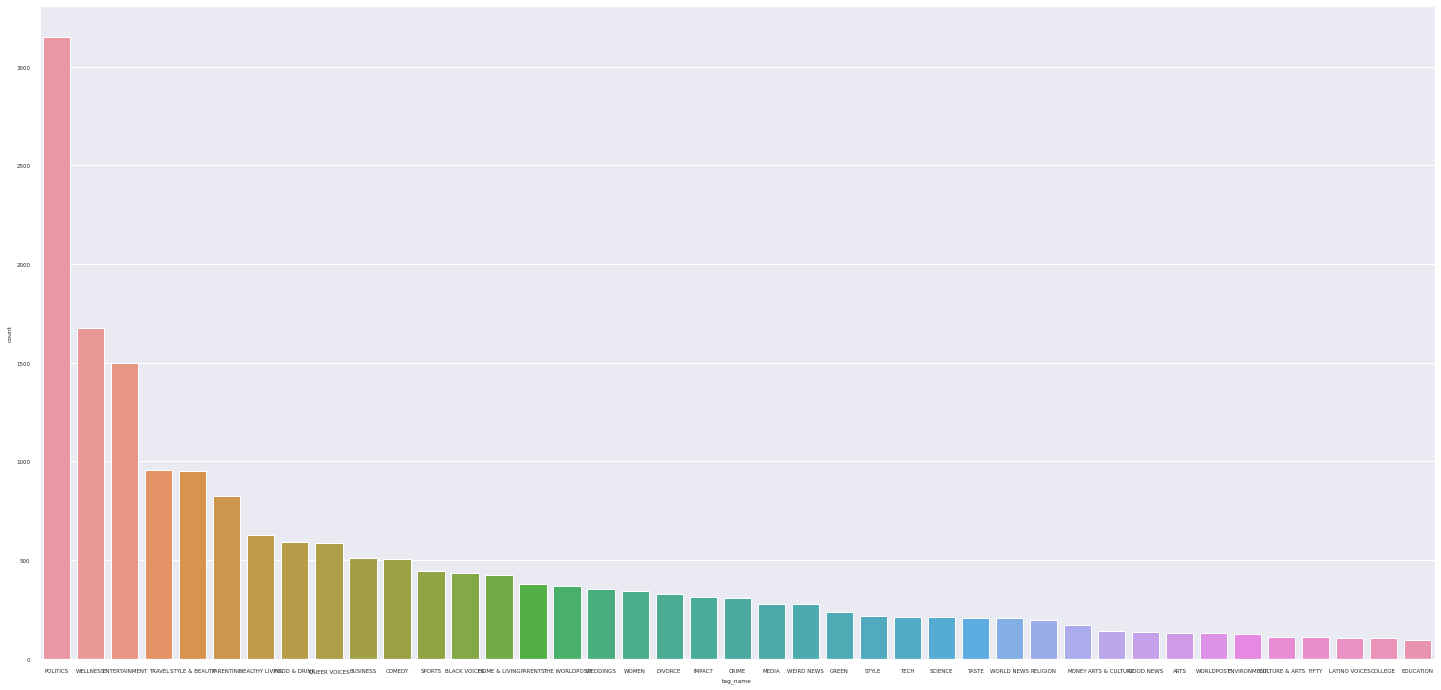

In [27]:
df = pd.DataFrame(y_test,columns=['targets'])             
index = pd.DataFrame(df.targets.value_counts().index)
counts = pd.DataFrame(df.targets.value_counts().values)
concat_df = pd.concat([index,counts],axis=1)
concat_df.columns =['tag','count']
# concat_df.head(2)
labels = [idx2tag[idx] for idx in index]
def get_names(x):
  return idx2tag[x]
concat_df['tag_name'] = concat_df.tag.apply(get_names)
plt.figure(figsize=(25,12))
sns.barplot(x="tag_name",y="count",data=concat_df)       ### Distribution of classes in Training set
sns.set(font_scale=0.5)

### MODEL 

In [0]:
V = len(tokenizer.vocab)
model = tf.keras.Sequential([
    
    tf.keras.layers.Embedding(V, 64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(41, activation='softmax')
])


#### Checkpoints

In [0]:
checkpoint_directory = "/content/drive/My Drive/NewsClassifier/LSTM/ckpts"
checkpoint = tf.train.Checkpoint(model=model) 
manager = tf.train.CheckpointManager(checkpoint,checkpoint_directory,max_to_keep=1)
if manager.latest_checkpoint:
  checkpoint.restore(manager.latest_checkpoint) #Restores this Checkpoint and any objects it depends on.
  print("Latest Checkpoint restored!! ") 

### Train

In [55]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])
num_epochs = 10
history = model.fit(X_train,y_train, epochs=num_epochs, verbose=2,batch_size=32,validation_data=(X_val,y_val))
manager.save()

Epoch 1/10
4740/4740 - 95s - loss: 0.9238 - sparse_categorical_accuracy: 0.7417 - val_loss: 1.1166 - val_sparse_categorical_accuracy: 0.7051
Epoch 2/10
4740/4740 - 93s - loss: 0.8699 - sparse_categorical_accuracy: 0.7542 - val_loss: 1.0931 - val_sparse_categorical_accuracy: 0.7115
Epoch 3/10
4740/4740 - 95s - loss: 0.8144 - sparse_categorical_accuracy: 0.7676 - val_loss: 1.0884 - val_sparse_categorical_accuracy: 0.7146
Epoch 4/10
4740/4740 - 93s - loss: 0.7752 - sparse_categorical_accuracy: 0.7790 - val_loss: 1.0977 - val_sparse_categorical_accuracy: 0.7152
Epoch 5/10
4740/4740 - 93s - loss: 0.7435 - sparse_categorical_accuracy: 0.7861 - val_loss: 1.1094 - val_sparse_categorical_accuracy: 0.7130
Epoch 6/10
4740/4740 - 92s - loss: 0.7140 - sparse_categorical_accuracy: 0.7939 - val_loss: 1.1149 - val_sparse_categorical_accuracy: 0.7157
Epoch 7/10
4740/4740 - 94s - loss: 0.6869 - sparse_categorical_accuracy: 0.8014 - val_loss: 1.1282 - val_sparse_categorical_accuracy: 0.7150
Epoch 8/10
47

'/content/drive/My Drive/NewsClassifier/LSTM/ckpts/ckpt-1'

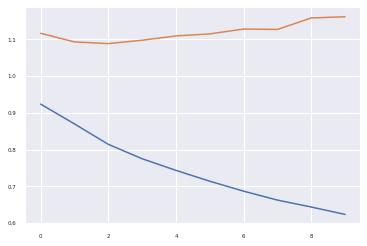

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

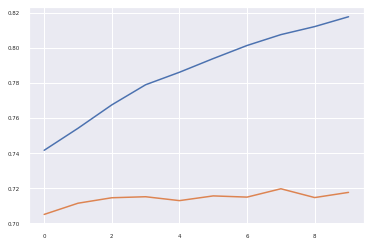

In [57]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])

In [58]:
results = model.evaluate(X_test,y_test)
print(results)

593/593 [==============================] - 2s 3ms/step - loss: 1.1714 - sparse_categorical_accuracy: 0.7130
[1.1714282035827637, 0.7129971385002136]
